In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import scipy as sp
import math

# Introduction to the Data Set and Purpose of Analysis

The purpose of this study is to determine what factors cause Singapore and Taiwan to have the highest 'World Happiness Index' score amongst developed East Asian countries (inclusive of Taiwan, Singapore, South Korea, Japan, Hong Kong and China). Through personal observations, I developed an interest in this topic (my general impression agrees with the WHI data) and wanted to explore deeper into what the route causes are.

Due to political reasons (global relations with China) it's difficult to find world datasets on development and equality that are inclusive of Taiwan. For example most of the World Bank development indicators do not include data on Taiwan even under the estimators for China. This led me to become interested in producing some of these indicator comparisons myself and see whether these can be used to draw any on why Taiwan has such a high WHI score (within Asia). 

The 'World Happiness Index' is a score calculated as part of a yearly 'World Happiness Report' produced through a parternship between Gallup, the Oxford Wellbeing Research Centre, the UN Sustainable Development Solutions Network and the WHR's Editorial Board. Details on the methodology for calculating the WHI score and it's explanatory indicators (including: GDP per capita in purchasing power parity
(PPP),  Healthy Life Expectancy (HLE),  Social support,  Freedom to make life choice, Generosity and Corruption Perception ) can be found in the Statistical Appendices for Chapter 2 of World Happiness Report.


## Definitions and abbreviations

<b> WHI: </b> World Happiness Index  

<i>The score calculated as part of a yearly 'World Happiness Report' produced through a parternship between Gallup, the Oxford Wellbeing Research Centre, the UN Sustainable Development Solutions Network and the WHR's Editorial Board.  </i> 

<b> PPP: </b> Purchasing Power Parity  

<i>  A measure of the price of specific goods in different countries and is used to compare the absolute purchasing power of the countries' currencies.  </i> 



<b> Countries of interest: </b> Taiwan, Singapore, South Korea, Japan, Hong Kong and China.

<i>Countries of interest include comparable developed East Asian countries. </i> 
 
<b> Relevant timeframe: </b> 2015 to 2025

<i> The relevant timeframe is constrained to the years in which the WHI report has been consequtively run, year on year  </i> 

In [2]:
#Import WHI Data 
#Using a for loop and string comprehension to import each individual year's csv file.
years = [i for i in range(2015, 2025)]
countries_of_interest = ['Taiwan', 'South Korea', 'Japan', 'Hong Kong', 'China', 'Singapore']
dfs = {year : pd.read_csv(str(year) + '.csv') for year in years}
# dfs

In [32]:
#Set up colour palette for consistent colours for countries of interest across whole report.
pal = dict(zip(countries_of_interest, sns.color_palette("bright", n_colors=len(countries_of_interest))))

In [3]:
#Column labels 'Country' and 'Happiness Score' are inconsistent across different year's dfs. Make their names the same across all dfs.

for year in years:
    for col in dfs[year].columns:
        #For Country
        if 'Country' in col:
            dfs[year] = dfs[year].rename(columns= {col:'Country'})
        #For Happiness Score
        if 'Score' in col:
            dfs[year] = dfs[year].rename(columns= {col:'Happiness Score'})
        if 'Ladder score in Dystopia' in col:
            continue
        elif 'Happiness score' in col:
            dfs[year] = dfs[year].rename(columns= {col:'Happiness Score'})
        elif 'Ladder score' in col:
            dfs[year] = dfs[year].rename(columns= {col:'Happiness Score'})

#Taiwan and HK are called a bunch of different things across each year's df. Make their names the same across all dfs.

for year in years:
    for row in dfs[year]['Country']:
        if 'S.A.R.' in row:
            dfs[year] = dfs[year].replace(row, 'Hong Kong')
        if 'Province' in row:
            dfs[year] = dfs[year].replace(row, 'Taiwan')

In [4]:
#For each year's df ensure the Happiness Index Column references the year.
dfs_happiness_by_year = {}
for year in years:
    dfs_happiness_by_year[year] = dfs[year].rename(columns={'Happiness Score': f'Happiness Score {year}'})
    
#Filter rows of each year's df to just display data relating to countries of interest
filtered_dfs = {}
for year in years:
    mask = dfs_happiness_by_year[year]['Country'].isin(countries_of_interest)
    filtered_df = dfs_happiness_by_year[year][mask]
    filtered_dfs[year] = filtered_df
    
#Filter columns to just display Country and Happiness Score 
country_happiness_dfs = {}
for year in years:
    country_happiness_dfs[year] = filtered_dfs[year][['Country',f'Happiness Score {year}']]

In [5]:
#Merge country happiness dfs one by one to create combined df.
combined_happiness_score_df = country_happiness_dfs[2015]
for year in years[:-1]:
    combined_happiness_score_df = pd.merge(left=combined_happiness_score_df, right=country_happiness_dfs[year+1])

#A bit of df reshuffling 
combined_happiness_score_df.columns = ['Country'] + [i for i in range(2015, 2025)] #CHANGE HERE WHEN UPDATING FILES
combined_happiness_score_df = combined_happiness_score_df.transpose()
combined_happiness_score_df = combined_happiness_score_df.rename(columns = combined_happiness_score_df.loc['Country']).iloc[1:]
#combined_happiness_score_df


# Figure 1: World Happiness Index Score against time 

The following line plot shows the 'World Happiness Index' score against time filtered for the countries of interest within the relevant timeframe.

/home/zoe/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/zoe/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


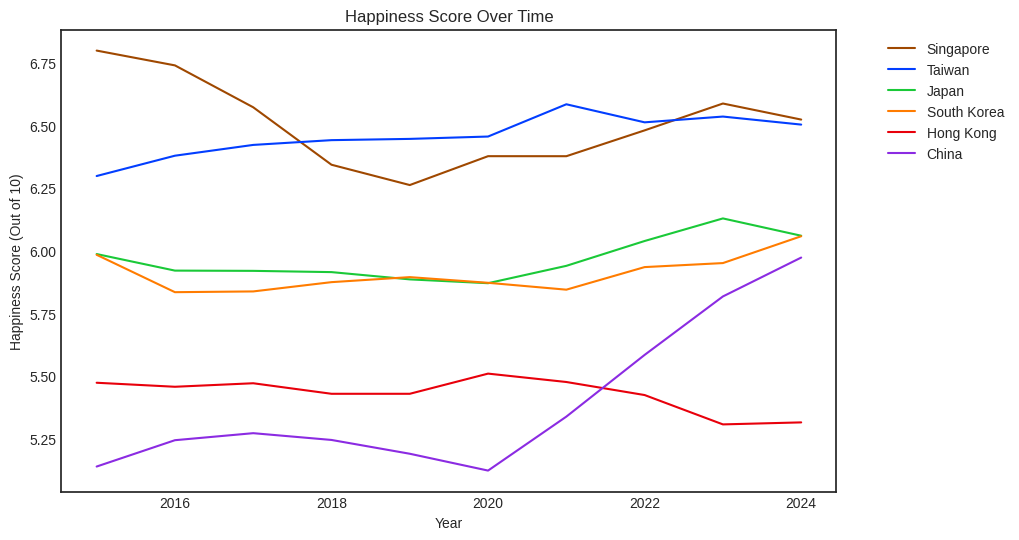

In [37]:
#Plot 1: a lineplot showing Happiness Score changing over time 
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(data=combined_happiness_score_df, palette=pal, dashes=False)
ax.set_xlabel('Year')
ax.set_ylabel('Happiness Score (Out of 10)')
# ax.set(xlim = (2015, 2024))
ax.set_title('Happiness Score Over Time')
plt.legend(bbox_to_anchor=(1.05,1), loc='best')

The data shows that the Happiness Score of Taiwan has been quite consistant over the past 10 years. Singapore and Taiwan are consistently the leaders within developed East Asian countries with Taiwan overtaking Singapore for first place in 2017 and SG reclaiming it's position in 2022.
'What makes these two countries the leader's in happiness index within this region?'
This question is the focus of this study.

As a first attempt to answer this question we will explore the impact of GDP based on PPP (purchasing power parity) per capita on the WHI score.

In [8]:
#Import and Clean PPP data
ppp_per_capita= 'ppp per capita.csv'

def data_cleaning(file):
        
    df = pd.read_csv(file)
    y_label = df.columns.values[0] 
    df.columns.values[0] = ''
    df = df.set_index('')
    df = df.transpose()
    df = df.reset_index()
    df= df.dropna(axis=1)
    df = df.rename({'index':'Year', 'Taiwan Province of China':'Taiwan', 'Hong Kong SAR': 'Hong Kong','Korea, Republic of':'South Korea', 'China, People\'s Republic of':'China'}, axis=1)
    df= df.iloc[:-4,:]
    df = df.replace({'no data':'NaN'})
    df = df.astype('float64')
    df = df.round(1)
    df['Year'] = df['Year'].astype('int')
    cols = ['Year'] + countries_of_interest
    tigers_df = df[cols]
    return tigers_df, y_label 


In [79]:
# PPP per capita DF
ppp_per_capita_df, ppp_per_capita_y_label = data_cleaning('ppp per capita.csv')
ppp_per_capita_df
long_form_ppp = pd.melt(ppp_per_capita_df,id_vars='Year', value_vars=countries_of_interest, var_name='Country', value_name='GDP per capita, current prices (PPP; US$ per capita')
# long_form_ppp

# Figure 2: PPP per capita against time

The following line plot shows GDP per capita, current prices (PPP; US$ per capita) score against time for the relevant timeframe.

/home/zoe/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/zoe/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(2021, 85000, '2021 - TW\novertakes HK')

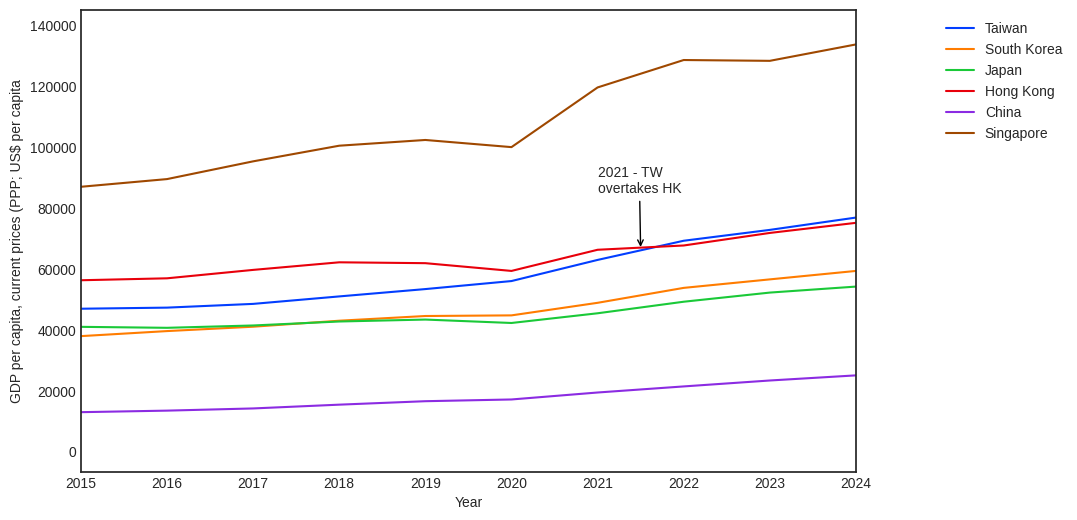

In [78]:
#Plot 2: a lineplot showing PPP per capita changing over time
plt.figure(figsize=(10,6))
plt.xlim((2015,2024))
sns.lineplot(data=long_form_ppp,x='Year', y='GDP per capita, current prices (PPP; US$ per capita)', hue='Country',dashes=False,palette=pal)
plt.legend(bbox_to_anchor=(1.1,1), loc='upper left')
plt.annotate('2021 - TW\novertakes HK',(2021.5,66280.7), (2021, 85000), arrowprops=dict(arrowstyle='->')) 

This plot shows both Singapore and Taiwan currently have the highest PPP values within developed Asia with Taiwan overtaking HK in 2021.
HK has mainted a similar PPP to Taiwan over time frame, however has one of the lowest WHI scores within developed Asia.

What makes Taiwan's WHI score so high, but HK's so low?
Next we will explore the impact of income equality (GINI Index) on the WHI score.

Data for GINI coefficients will be taken from most recent data in the World Bank column from the income inequality wikipedia entry. (For some reason this includes Taiwan, unlike the official World Bank website.)

In [12]:
#Create dictionary of GINI data
gini_dict =  {'Countries': countries_of_interest, 'Gini Coefficient':[34.1, 31.4, 32.9, 53.9,37.1, 45.9]}
gini_df = pd.DataFrame(gini_dict,index =countries_of_interest)
# display(gini_df)

In [13]:
#Transpose happiness score df and calculate the 10 year average
transposed_happiness_df = combined_happiness_score_df.transpose()
transposed_happiness_df['WHI Score Average'] = transposed_happiness_df.mean(axis=1)
# transposed_happiness_df

In [28]:
#Merge both data frames on countries
combined_gini_happiness_df = pd.merge(left=transposed_happiness_df, right=gini_df, left_index=True, right_index=True)
# combined_gini_happiness_df

,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,WHI Score Average,Countries,Gini Coefficient
Singapore,6.798,6.739,6.572,6.343,6.262,6.3771,6.377,6.48,6.587,6.523,6.50581,Singapore,45.9
Taiwan,6.298,6.379,6.422,6.441,6.446,6.4554,6.584,6.512,6.535,6.503,6.45754,Taiwan,34.1
Japan,5.987,5.921,5.92,5.915,5.886,5.8708,5.94,6.039,6.129,6.06,5.96678,Japan,32.9
South Korea,5.984,5.835,5.838,5.875,5.895,5.8724,5.845,5.935,5.951,6.058,5.90884,South Korea,31.4
Hong Kong,5.474,5.458,5.472,5.43,5.43,5.5104,5.477,5.425,5.308,5.316,5.43004,Hong Kong,53.9
China,5.14,5.245,5.273,5.246,5.191,5.1239,5.339,5.585,5.818,5.973,5.39339,China,37.1


# Figures 3 and 4: GINI vs averaged WHI score over the past 10 years

<Axes: xlabel='Countries', ylabel='Gini Coefficient'>

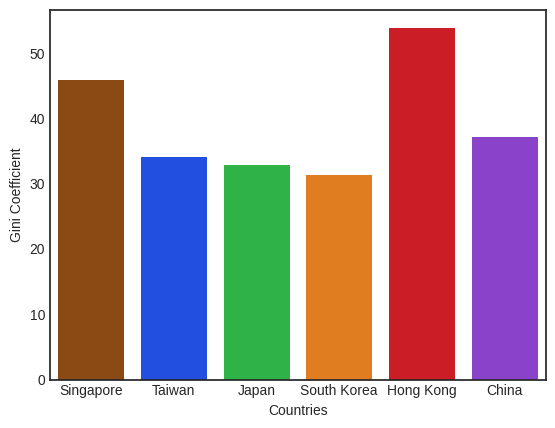

In [34]:
sns.barplot(combined_gini_happiness_df, x='Countries', y='Gini Coefficient', palette=pal)

<Axes: xlabel='Gini Coefficient', ylabel='WHI Score Average'>

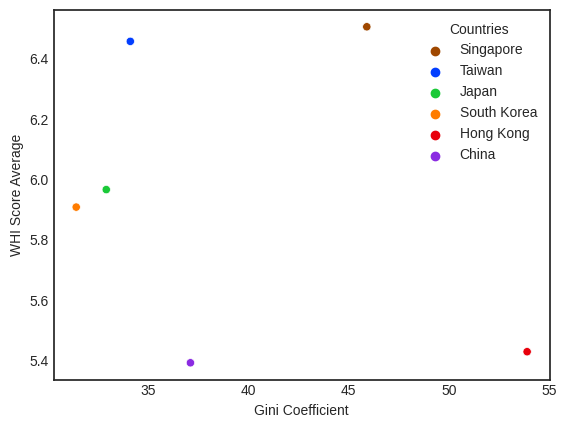

In [35]:
sns.scatterplot(combined_gini_happiness_df, x= 'Gini Coefficient', y='WHI Score Average', hue='Countries',palette=pal)

As hypothesized Hong Kong has a very high income inequality (Gini coefficient) that correlate to it's low WHI score. China exhibits a similar trend Singapore seems to be an abnormality as despite having high income inequality, it has a high WHI score. 
It appears that GINI coefficient alone is not sufficient to explain the happiness score within developed Asian countries. 
Next we will explore whether there any particular indictor in which Singapore is outstanding that causes it to have such a high WHI score. 

# Figures 5 to 11: WHI indicators (2020) for each country of interest

The purpose of the following plots are to determine which indicators outside of GINI score lead to Singapore's high WHI score within developed Asian countries (particularly with comparison to Hong Kong) and whether Taiwan and Singapore share any similarities that account for their similarly high scores.  For convinience, only data from 2020 has been plotted (2020 was the only year in which the WHI provided clear raw data on all the indictors). Any conclusions are assuming indicators do not significantly change over the years.


In [80]:
mask_2020 = dfs[2020]['Country'].isin(countries_of_interest)
filtered_df_2020 = dfs[2020][mask_2020]
# filtered_df_2020

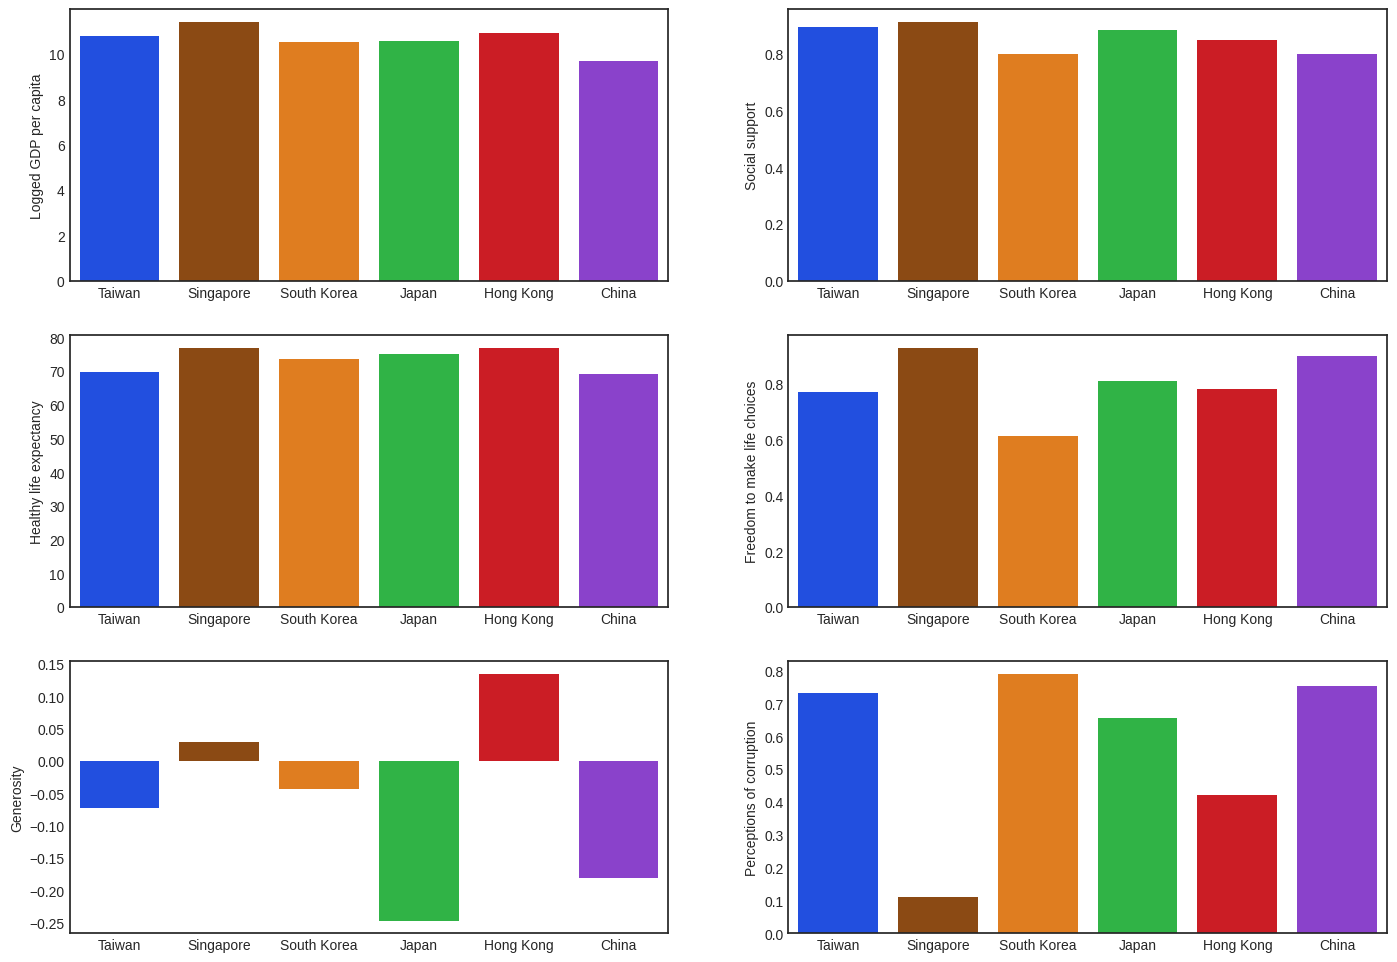

In [36]:
fig,axs = plt.subplots(3,2, figsize=(17,12))
plt.style.use('seaborn-v0_8-white')
sns.barplot(ax = axs[0,0], data=filtered_df_2020, x='Country', y='Logged GDP per capita', palette=pal)
sns.barplot(ax = axs[0,1],data=filtered_df_2020, x='Country', y='Social support', palette=pal)
sns.barplot(ax = axs[1,0],data=filtered_df_2020, x='Country', y='Healthy life expectancy', palette=pal)
sns.barplot(ax = axs[1,1],data=filtered_df_2020, x='Country', y='Freedom to make life choices', palette=pal)
sns.barplot(ax = axs[2,0],data=filtered_df_2020, x='Country', y='Generosity', palette=pal)
sns.barplot(ax = axs[2,1],data=filtered_df_2020, x='Country', y='Perceptions of corruption', palette=pal)

axs[0,0].xaxis.label.set_visible(False)
axs[0,1].xaxis.label.set_visible(False)
axs[1,0].xaxis.label.set_visible(False)
axs[1,1].xaxis.label.set_visible(False)
axs[2,0].xaxis.label.set_visible(False)
axs[2,1].xaxis.label.set_visible(False)


Singapore and Hong Kong have similar scores across most of the indicators (bearing in mind this is just for 2020, peoples impressions of how goverments dealt with Covid-19 may have significantly impacted these scores).

Singapore is 1st within the countries of interest for the following indicators: GDP, social upport, freedom to make life choices and perception of corruption and is 2nd for the remaining indicators: Life expectancy, generosity. 

Singapore performs particulary well in perception of corruption where it is a quarter of the second lowest country (Hong Kong) within the countries of interest. The defintion from the WHI appendices being: 'The measure is the national average of the survey responses to two questions in the Gallup World Poll: “Is corruption widespread throughout the government or not” and “Is corruption widespread within businesses or not?” 

Other than perceptions of corruption there are no signficant differences in indicactor scores between Singapore and Hong Kong. 

There are also no notable oustanding characteristics shared by Taiwan and Singapore that set them apart from other countries apart from them both performing well across all indicators. 

Several key points regarding Singapore that may or may not be relevant: 

Singapore historically has always been a very politically stable country (with the current ruling party PAP being dominant since 1959). 

Singapore also has the smallest population out of the countries being compared in this study (5.6 million (2022)). 

# Conclusions and future work 

In conclusion, both Taiwan and Singapore have high GDP (PPP) per capita which contributes to their high WHI scores. However, Hong Kong also has a high GDP but a lower WHI score so this can not be the only explaination. The impact of income inequality (GINI index) was investigated as an attempt to account for this discrenpency. Whilst Hong Kong does have a higher income inequality compared to Taiwan, Singapore also has a high GINI index whilst exhibiting a very high WHI score. WHI indicators were analysed to determine what sets Singapore apart from Hong Kong and whether Taiwan/Singapore have any outstanding charactertistics. The main difference found was that Singapore has a very low perception of corrruption. Taiwan and Singapore both perform broadly well across all indicators.  


The following points are beyond the scope of this report for analysing quantitively for however these are things I have noticed qualitively that would be interesting to analyse in the future.

Taiwan and Singapore have the following similarities:

1. Both countries are culturally diverse, use a variety of different languages and are generally quite accepting and accomodating to foreigners/ outside influences. This makes them adaptable and open to development.
2. Both countries have a history of being colonized by Japan. This has impacted the society of 'orderliness'. 
3. Both countries have a strong emphasize on English education.
4. Both countries are considered quite liberal and progressive in terms of LGBT rights and feminism compared to other developed Asian countries.
   
